## Classification of dominant gaz in a room

### Step 1: Define Objectives

The goal of this project is to be able to classify (identify) dominant gaz in room given input data measured by 4 MQ sensors (MQ-135, MQ-9, MQ-7 and MQ-6).

An arduino nano, connected to the 4 sensors through its analog inputs, is used to collect data and send it to Raspberry pi via USB cable every 10 secondes. The Raspberry Pi runs a Node-red web server to collect the data and forward this data to a Flask local web service that run a model to predict the type of gaz present in the room.

To build the model, training data is required. So I've collected around 8000 observations during which the 4 sensors are exposed to 5 differents types of polluant gas : CO2/Smoke (4522 observations), Alchool (996), Flammable gas (780), exhaust gas (696) and CO (336). Please find attached these data in csv formatted file.
So let's begin!

### Step 2: Import libraries and load csv file

#### Import required libraries

In [1]:
import pandas as pd
from warnings import filterwarnings
filterwarnings(action='ignore')


#### Load csv data (data have been well prepared so there is no missing values). But outliers are present, so we will deal with them later

In [2]:
df = pd.read_csv('airQdata.csv', sep=',')
df.sample(5)

,Q1,Q2,Q3,Q4,Class
6745,626,507,646,754,EXHAUST_GAS
1301,405,279,359,401,CO2/SMOKE
5177,345,243,279,404,CO2/SMOKE
207,400,393,620,749,ALCHOOL
3424,356,278,289,482,CO2/SMOKE


#### How many possible values are in the class column?

In [3]:
df['Class'].value_counts()

CO2/SMOKE        4522
ALCHOOL           996
FLAMMABLE_GAS     780
EXHAUST_GAS       696
CO                336
Name: Class, dtype: int64

Store those values in a variable called target_names for later use

In [4]:
target_names = ['CO2/SMOKE', 'ALCHOOL',
                'FLAMMABLE_GAS', 'CO', 'EXHAUST_GAS']

### Step 3: Data exploration

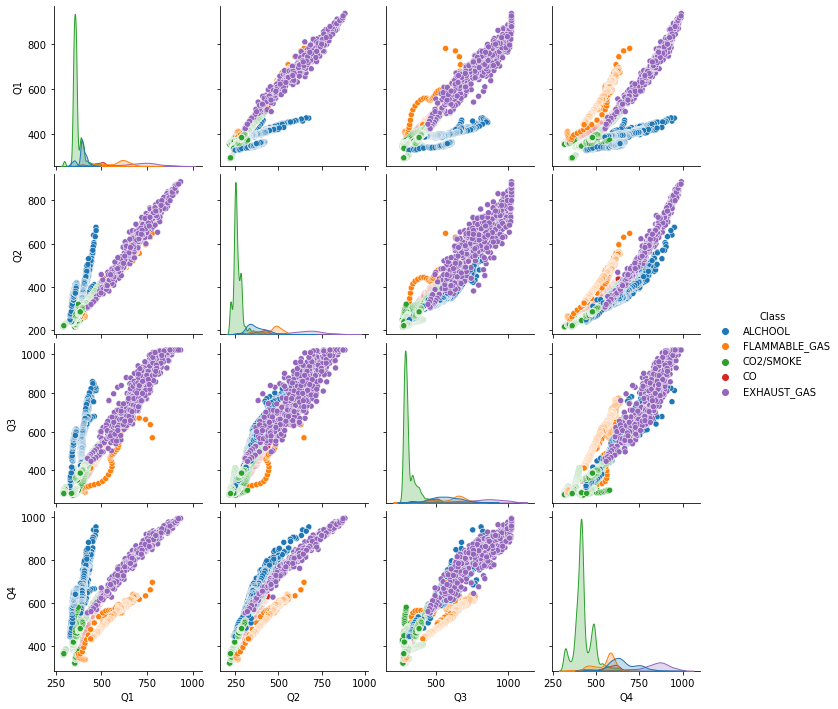

In [5]:
import seaborn as sns
sns.pairplot(df, hue='Class')


As you can see, each features (Q1, ...Q4) are highly corralated. So maybe, some features could be removed to clean a little bit the data and make the algo happy.

#### Encode categorical data (the class column) into number which is required by every algo. Then separe features and target and store them to numpy array variable X and y.

In [6]:
import numpy as np
def encodeClass(x):
    if x == 'CO2/SMOKE':
        return 0
    elif x == 'ALCHOOL':
        return 1
    elif x == 'FLAMMABLE_GAS':
        return 2
    elif x == 'CO':
        return 3
    else:
        return 4

X = np.array(df.drop('Class', axis=1))
y = np.array(df.Class.apply(encodeClass))
X.shape, y.shape

((7330, 4), (7330,))

#### Train test split

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (5864, 4)
X_test shape: (1466, 4)


#### Data standardization

In [8]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler(feature_range=(0, 1))
X_train = minmax.fit_transform(X_train)
X_test = minmax.transform(X_test)

#### Let's apply PCA Algorithm to reduce the dimension of our dataset to just 2 dimensions instead of 4 to better visualize and see if each class (gas type) are separeted.

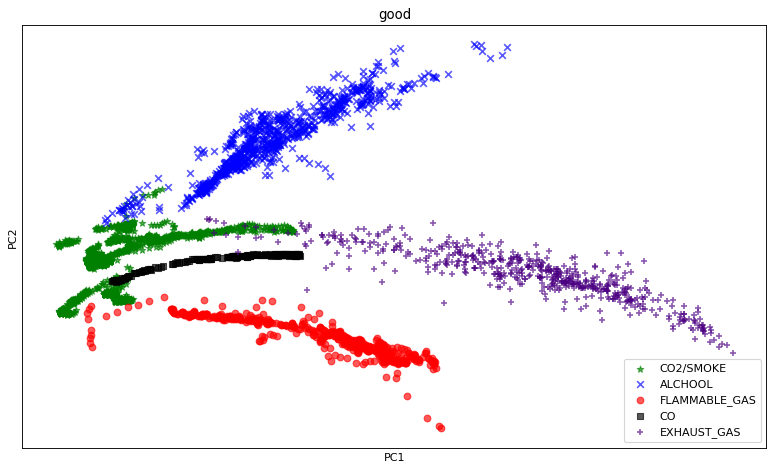

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Scatter plot of data
markers = ('*', 'x', 'o', 's', '+')
colors = ('green', 'blue', 'red', 'black', 'Indigo')
plt.figure(figsize=(12, 7), dpi=80)
for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x=X_train[y_train == cl, 0], y=X_train[y_train == cl, 1],
                alpha=0.65, c=colors[idx],
                marker=markers[idx], label=target_names[cl], edgecolor=colors[idx])
plt.xlabel('PC1')
plt.xticks([])
plt.ylabel('PC2')
plt.yticks([])
plt.title('good')
plt.legend(loc="lower right")
plt.show()


As you can see, each class (gaz) is almost separeted one from others. Except the fact that Alchool and CO2/SMOKE are partially overlapped. The same goes for CO2/SMOKE and CO as well as Exhaust gas.

#### You can confirm these finding by looking at boxplot of each gaz 

<AxesSubplot:xlabel='Class', ylabel='Q4'>

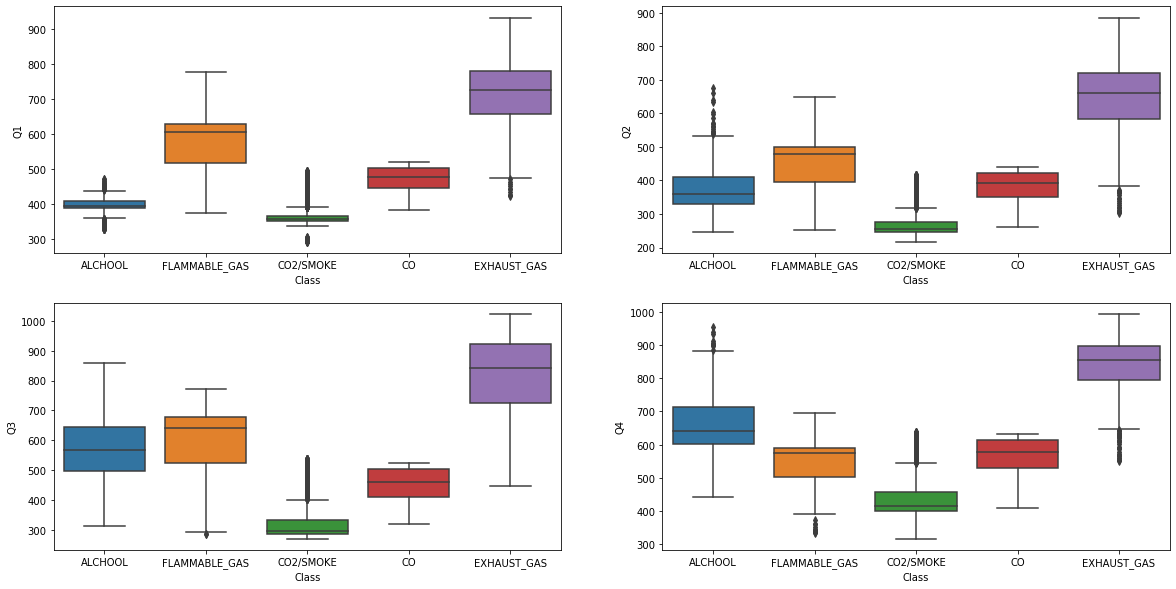

In [10]:
plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
sns.boxplot(x='Class', y='Q1', data=df)
plt.subplot(2, 2, 2)
sns.boxplot(x='Class', y='Q2', data=df)
plt.subplot(2, 2, 3)
sns.boxplot(x='Class', y='Q3', data=df)
plt.subplot(2, 2, 4)
sns.boxplot(x='Class', y='Q4', data=df)


### Step 4: Remove Outliers

#### To reduce these problems of overlapping, let's remove outliers in each gaz type.

In [11]:
from sklearn.covariance import EllipticEnvelope
import numpy as np

# I choose conta (contamination) 0.2.
# But you can increase or decrease this value if you want and see the result.
def removeOutlier(df, x, conta=.2):
    df_gaz = df[df.Class == x].reset_index().drop(
        columns='index').drop(columns='Class')

    outlier_detector = EllipticEnvelope(contamination=conta)
    # Fit detector
    outlier_detector.fit(df_gaz)
    # Predict outliers
    df_gaz['Class'] = outlier_detector.predict(df_gaz)
    df_gaz = df_gaz[df_gaz['Class'] == 1].replace(1, x)
    df_gaz = df_gaz.reset_index()
    df_gaz = df_gaz.drop(columns='index')
    df = df.reset_index().drop(columns='index')
    df = df[df['Class'] != x]
    df = pd.concat([df, df_gaz], axis=0).reset_index().drop(columns='index')
    return df

for gaz in target_names:
    df = removeOutlier(df, gaz)

### Visualize data without outliers

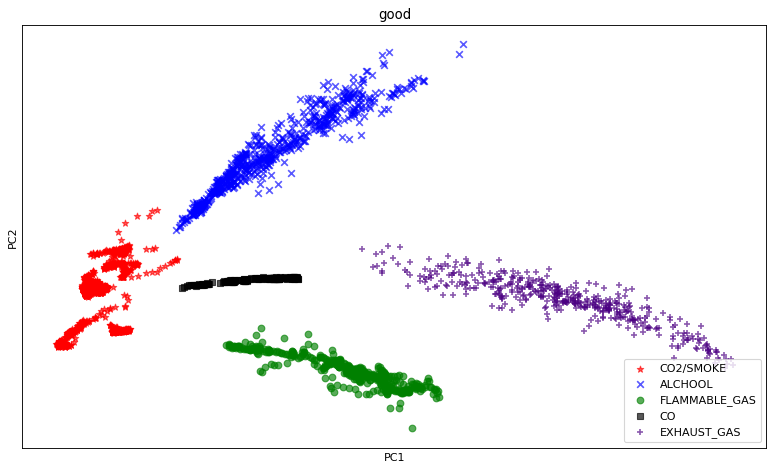

In [12]:
X = np.array(df.drop('Class', axis=1))
y = np.array(df.Class.apply(encodeClass))

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y)

minmax = MinMaxScaler(feature_range=(0, 1))
X_train = minmax.fit_transform(X_train)
X_test = minmax.transform(X_test)

pca = PCA(n_components=2)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Scatter plot of data
markers = ('*', 'x', 'o', 's', '+')
colors = ('red', 'blue', 'green', 'black', 'Indigo')
plt.figure(figsize=(12, 7), dpi=80)
for idx, cl in enumerate(np.unique(y)):
    plt.scatter(x=X_train[y_train == cl, 0], y=X_train[y_train == cl, 1],
                alpha=0.65, c=colors[idx],
                marker=markers[idx], label=target_names[cl], edgecolor=colors[idx])
plt.xlabel('PC1')
plt.xticks([])
plt.ylabel('PC2')
plt.yticks([])
plt.title('good')
plt.legend(loc="lower right")
plt.show()


Data are now well separeted one from others.
We can start training process

#### Step 5: Train random forest classifier with hyperparameter tuning

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV

# Create a pipeline
pipe = Pipeline([("classifier", RandomForestClassifier())])

# Create dictionary with candidate learning algorithms and their hyperparameters
search_space = [{"classifier": [RandomForestClassifier(class_weight='balanced')],
                 "classifier__n_estimators": [10, 20],
                 "classifier__min_samples_split": [5, 10, 20],
                 "classifier__min_samples_leaf": [1, 2, 4, 10],
                 "classifier__bootstrap": [True, False],
                 "classifier__criterion": ['gini', 'entropy'],
                 "classifier__max_features": [1,2]}]

# Create grid search
randomsearch = RandomizedSearchCV(
    pipe, search_space, n_iter=30, cv=5, verbose=1,scoring="accuracy", n_jobs=-1)
# Fit grid search
best_model = randomsearch.fit(X_train, y_train)

#Print best_model hyperparameters
best_model.best_estimator_.get_params()['classifier']


Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomForestClassifier(class_weight='balanced', max_features=1,
                       min_samples_leaf=10, min_samples_split=20,
                       n_estimators=20)

### step 6: Evaluate this best_model with cross-validation

In [14]:
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score

# Create StratifiedKFold cross-validation
kf = StratifiedShuffleSplit(n_splits=5, test_size=.2, random_state=1)
# Conduct k-fold cross-validation
cv_results = cross_val_score(best_model,  # Pipeline
                             X_train,  # Feature matrix
                             y_train,  # Target vector
                             cv=kf,  # Cross-validation technique
                             scoring="accuracy",  # Loss function
                             n_jobs=-1)  # Use all CPU scores

#Print the results
print(cv_results)


[1.         1.         1.         1.         0.99893504]


The best model is pretty accurate on the training set.
Now let's evaluate it with the test set and print the confusion matrix to see the predicted values against actuals values.

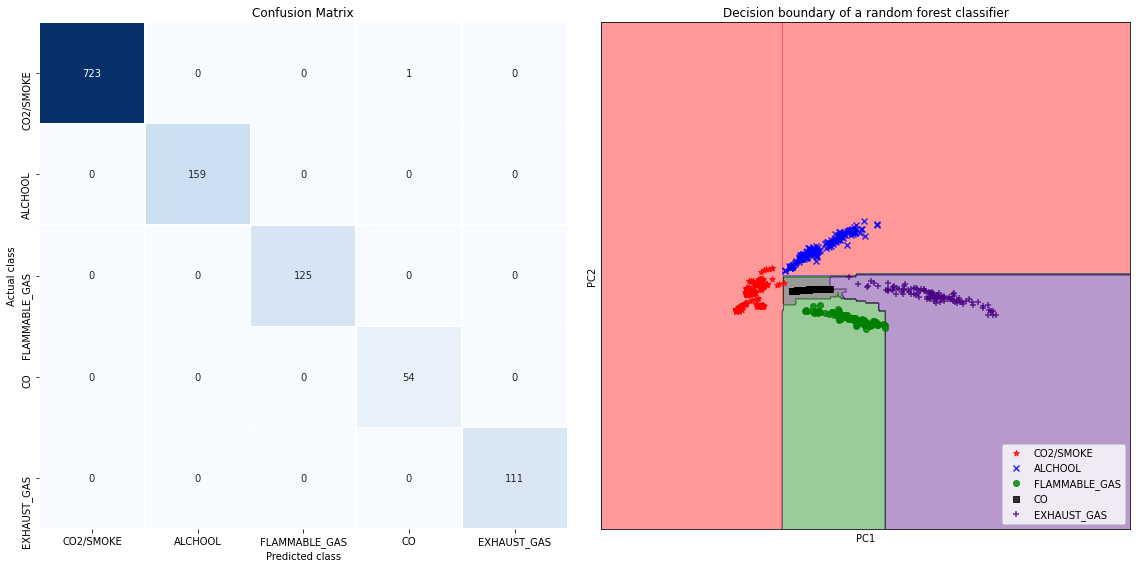

In [15]:
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap

# Plot confusion matrix
y_pred = best_model.predict(X_test)

# -----------------------------------------------------
# Plot confusion matrix
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(16, 8))
cm = confusion_matrix(y_test, y_pred)  # , labels= target_names)
sns.heatmap(cm, annot=True, cbar=False, fmt="d",
            linewidths=.5, cmap="Blues", ax=ax1)
ax1.set_title("Confusion Matrix")
ax1.set_xlabel("Predicted class")
ax1.set_ylabel("Actual class")
ax1.set_xticklabels(target_names)
ax1.set_yticklabels(target_names)
fig.tight_layout()
# -----------------------------------------------------
# Plot the decision boundary
cmap = ListedColormap(colors[:len(np.unique(y_test))])
# plot the decision surface
x1_min, x1_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
x2_min, x2_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
resolution = 0.01  # step size in the mesh
xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                       np.arange(x2_min, x2_max, resolution))
Z = randomsearch.best_estimator_.predict(np.c_[xx1.ravel(), xx2.ravel()])
# Put the result into a color plot
Z = Z.reshape(xx1.shape)
plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
# plot class samples
for idx, cl in enumerate(np.unique(y_test)):
    plt.scatter(x=X_test[y_test == cl, 0],
                    y=X_test[y_test == cl, 1],
                    alpha=0.8,
                    c=colors[idx],
                    marker=markers[idx],
                    label=target_names[cl],
                    edgecolor=colors[idx])
ax2.set_title('Decision boundary of a random forest classifier')
ax2.set_xlabel("PC1")
ax2.set_ylabel("PC2")
plt.xlim(xx1.min(), xx1.max())
plt.ylim(xx2.min(), xx2.max())
plt.xticks([])
plt.yticks([])
plt.legend(loc='lower right')
plt.show()



Conclusion:

Model is almost 100% accurate. 

Only one mis-prediction: the model predicted one CO2/SMOKE gaz as CO. At least for my case, yours may be different.

### Step 7: Save the best model in current working directory

In [17]:
import pickle
import os

#save knn
path = os.getcwd()+'/RF_Model.pkl'
file = open(path, 'wb')
pickle.dump(best_model, file)